# 1. Load the data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi']= 100
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_X = pd.read_csv('train_features.csv', index_col='match_id_hash')
train_X.head(2)

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,22,7,1,11,11,0,0,0,0,...,0.0,0,0,0,0,0.0,0,0,0,0
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0.0,0,0,0,0,0.0,0,0,0,0


In [3]:
#train_X.info(max_cols=250)
train_X.isna().sum().sum()

0

There are no missing values in the data. 30 variables have type float. The rest are of integer type, which can, in fact be categorical (ordinal and not ordinal) data. We can look at the distribution of the values trying to spot any outliers. 

# 2. Check if the classes are balanced

In [27]:
# load target data
target = pd.read_csv('train_targets.csv', index_col = 'match_id_hash')
y = target['radiant_win']
# combine target column and the train data
full_df = train_X.merge(y, how='outer', left_index=True, right_index=True)
full_df.head(2)

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed,radiant_win
match_id_hash,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,22,7,1,11,11,0,0,0,0,...,0,0,0,0,0.0,0,0,0,0,False
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0,0,0,0,0.0,0,0,0,0,True


In [42]:
# checking the class balance
radiant_win_T = full_df[full_df['radiant_win'] == 1].shape[0]
radiant_win_F = full_df[full_df['radiant_win'] == 0].shape[0]
print('Percentage of games won by Radiant is {}'.format(radiant_win_T/(radiant_win_T+radiant_win_F)))


Percentage of games won by Radiant is 0.5249149338374292


The classes are almost balanced, so no need to upsample the classes

# 3. Check the binary features

In [15]:
def select_cols_n_distinct(data,d_min,d_max):
    '''select columns in data frame with number of 
    distinct values between min and max, inclusive'''
    cols = []
    for col in data.columns.values:
        unique_vals = data[col].value_counts().shape[0]
        if unique_vals >= d_min and unique_vals <= d_max:
            #cols.append((col,unique_vals))
            cols.append(col)
    return cols    

In [22]:
# determine binary features
select_cols_n_distinct(train_X,2,2)

['lobby_type',
 'r1_firstblood_claimed',
 'r2_firstblood_claimed',
 'r3_firstblood_claimed',
 'r4_firstblood_claimed',
 'r5_firstblood_claimed',
 'd1_firstblood_claimed',
 'd2_firstblood_claimed',
 'd3_firstblood_claimed',
 'd4_firstblood_claimed',
 'd5_firstblood_claimed']

### Lobby type

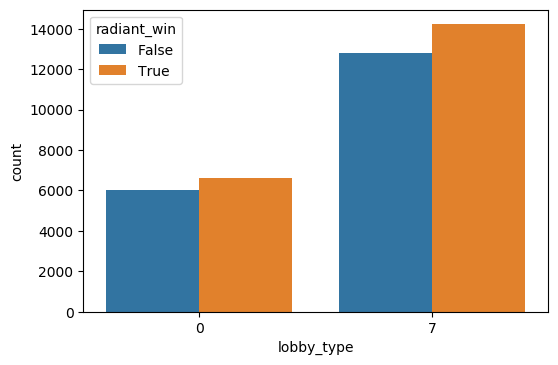

In [74]:
sns.countplot(x="lobby_type", hue="radiant_win", data=full_df)

In [68]:
#scale lobby_type
full_df.loc[full_df.lobby_type == 7]['lobby_type'] = 1

### First blood claimed

In [69]:
new_features = pd.DataFrame(index=train_X.index)

In [84]:
# look at firstblood_claimed though all players
r_firstblood_claimed = ['r{}_firstblood_claimed'.format(i) for i in range(1,6)]
d_firstblood_claimed = ['d{}_firstblood_claimed'.format(i) for i in range(1,6)]
firstblood_claimed = r_firstblood_claimed+d_firstblood_claimed
print(full_df.loc[:,firstblood_claimed].sum(axis=1).value_counts())

1    36471
0     3204
dtype: int64


It seems that the first blood can only be claimed by only one player from either team, i.e. the aggregated value for ech team still remain binary.

In [77]:
# first_blood_claimed by Radiant

new_features['r_firstblood_claimed'] = full_df.loc[:,r_firstblood_claimed].sum(axis=1)
new_features['r_firstblood_claimed'].value_counts()

0    28631
1    11044
Name: r_firstblood_claimed, dtype: int64

In [78]:
# first_blood_claimed by Dire

new_features['d_firstblood_claimed'] = full_df.loc[:,d_firstblood_claimed].sum(axis=1)
new_features['d_firstblood_claimed'].value_counts()

0    21642
1    18033
Name: d_firstblood_claimed, dtype: int64

In [79]:
new_features['target'] = full_df['radiant_win']

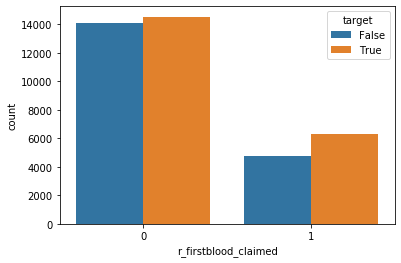

In [80]:
sns.countplot(x="r_firstblood_claimed", hue="target", data=new_features);#,ax=axs[0]);

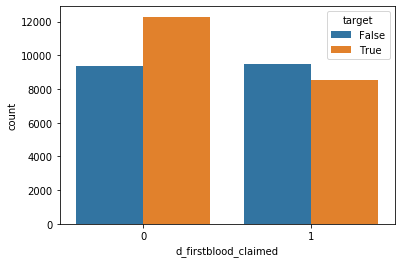

In [81]:
sns.countplot(x="d_firstblood_claimed", hue="target", data=new_features);

# 4. Check other categorical features

### Game mode

count    39675.000000
mean        19.584776
std          6.304976
min          2.000000
25%         22.000000
50%         22.000000
75%         22.000000
max         23.000000
Name: game_mode, dtype: float64
22    31762
4      3564
23     2546
3      1200
2       408
5       188
12        5
16        2
Name: game_mode, dtype: int64


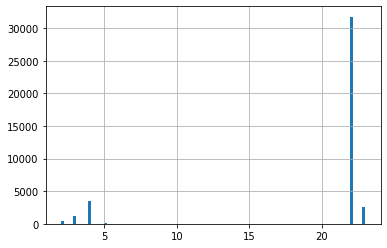

In [87]:
feat = 'game_mode'
print(full_df[feat ].describe())
print(full_df[feat ].value_counts())
train_X[feat ].hist(bins = 100)
plt.show()

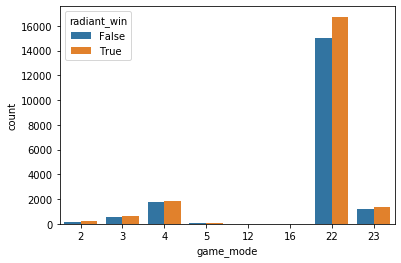

In [88]:
sns.countplot(x="game_mode", hue="radiant_win", data=full_df)

### Level

count    39675.000000
mean        11.238513
std          6.808209
min          1.000000
25%          5.000000
50%         11.000000
75%         16.000000
max         25.000000
Name: d5_level, dtype: float64
4     2294
5     2188
13    2135
3     2058
6     2057
9     1991
7     1945
14    1852
8     1845
2     1830
10    1776
1     1753
15    1749
11    1738
25    1729
12    1701
16    1406
17    1242
18    1239
19    1049
20     968
21     926
22     832
23     765
24     607
Name: d5_level, dtype: int64


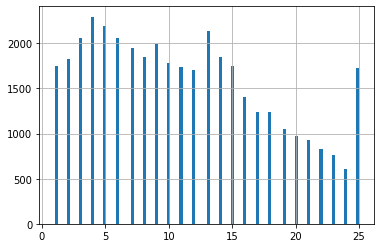

In [89]:
fet = 'd5_level'
print(train_X[fet].describe())
print(train_X[fet].value_counts())
train_X[fet].hist(bins = 100)
plt.show()

In [94]:
train_X[['d1_level','d2_level','d3_level','d4_level','d5_level']].head()

,d1_level,d2_level,d3_level,d4_level,d5_level
match_id_hash,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,3,3,2,2,3
b9c57c450ce74a2af79c9ce96fac144d,7,6,7,6,4
6db558535151ea18ca70a6892197db41,1,1,1,1,1
46a0ddce8f7ed2a8d9bd5edcbb925682,6,7,6,4,5
b1b35ff97723d9b7ade1c9c3cf48f770,5,5,7,4,5


Players within the team may have different levels. Thus, for the aggregation we should consider average, min and max level of the players within the team.

### Conclusions about categorical variables:
* firstblood_claimed : categorical, binary
* game_mode: categorical, non-ordinal --> needs to be converted to dummy variables
* lobby_type: categorical, binary (value 7 chould be changes with 1)
* hero_id: categorical, non-ordinal (too many levels) --> remove from consideration
* level: categorical, ordinal (25 levels) ---> should consider avrage, min and max for aggregation

# 5. Check numerical data

### roshans_killed

In [102]:
r_roshans_killed = ['r{}_roshans_killed'.format(i) for i in range(1,6)]
new_features['r_roshans_killed'] = train_X.loc[:,r_roshans_killed].sum(axis=1)
new_features['r_roshans_killed'].value_counts()


0    34807
1     4051
2      722
3       88
4        6
5        1
Name: r_roshans_killed, dtype: int64

In [100]:
roshans_killed_d = ['d{}_roshans_killed'.format(i) for i in range(1,6)]
new_features['d_roshans_killed'] = train_X.loc[:,roshans_killed_d].sum(axis=1)
new_features['d_roshans_killed'].value_counts()

0    35234
1     3662
2      669
3       95
4       13
5        2
Name: d_roshans_killed, dtype: int64

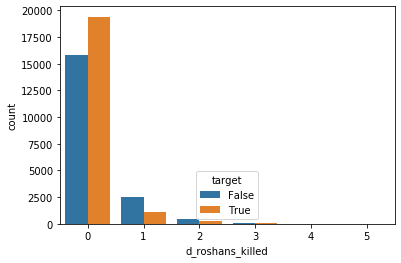

In [101]:
sns.countplot(x="d_roshans_killed", hue="target", data=new_features);

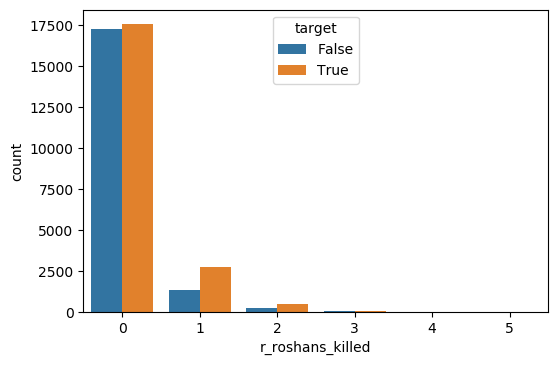

In [143]:
sns.countplot(x="r_roshans_killed", hue="target", data=new_features);

### towers_killed

In [103]:
d_towers_killed = ['d{}_towers_killed'.format(i) for i in range(1,6)]
r_towers_killed = ['r{}_towers_killed'.format(i) for i in range(1,6)]
new_features['d_towers_killed'] = train_X.loc[:,d_towers_killed].sum(axis=1)
new_features['r_towers_killed'] = train_X.loc[:,r_towers_killed].sum(axis=1)
print(new_features['d_towers_killed'].value_counts())
print(new_features['d_towers_killed'].value_counts())

0     19123
1      6121
2      4384
3      3142
4      2389
5      1734
6      1352
7       782
8       420
9       165
10       51
11       11
12        1
Name: d_towers_killed, dtype: int64
0     19123
1      6121
2      4384
3      3142
4      2389
5      1734
6      1352
7       782
8       420
9       165
10       51
11       11
12        1
Name: d_towers_killed, dtype: int64


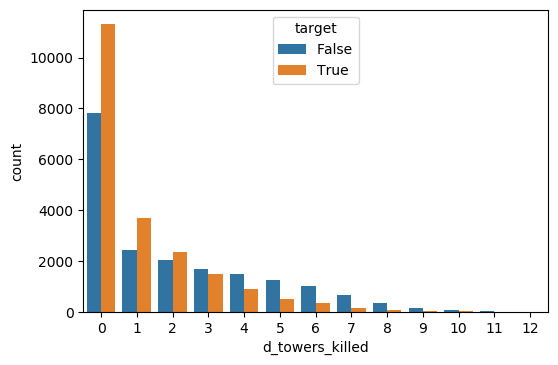

In [157]:
sns.countplot(x="d_towers_killed", hue="target", data=new_features);

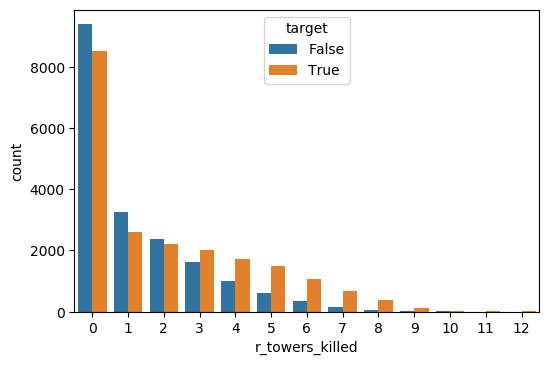

In [158]:
sns.countplot(x="r_towers_killed", hue="target", data=new_features);

### camps_stacked

In [104]:
d_camps_stacked = ['d{}_camps_stacked'.format(i) for i in range(1,6)]
r_camps_stacked = ['r{}_camps_stacked'.format(i) for i in range(1,6)]
new_features['d_camps_stacked'] = train_X.loc[:,d_camps_stacked].sum(axis=1)
new_features['r_camps_stacked'] = train_X.loc[:,r_camps_stacked].sum(axis=1)
#print(new_features['d_camps_stacked'].value_counts())
#print(new_features['d_camps_stacked'].value_counts())

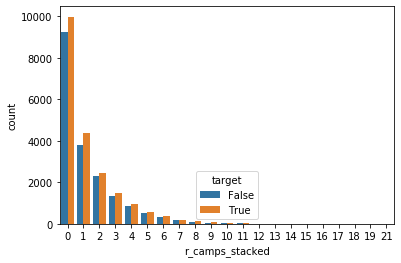

In [105]:
sns.countplot(x="r_camps_stacked", hue="target", data=new_features);

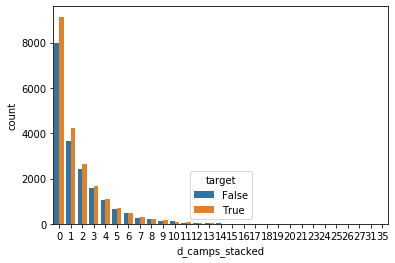

In [106]:
sns.countplot(x="d_camps_stacked", hue="target", data=new_features);

### chat_length

count    39675.000000
mean         7.338500
std         13.366381
min          0.000000
25%          0.000000
50%          3.000000
75%          9.000000
max        291.000000
Name: chat_len, dtype: float64


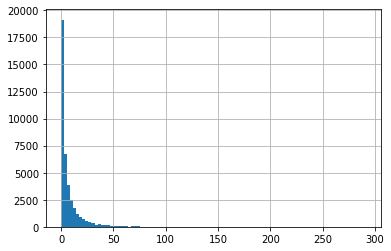

Percentage of chats longer than 100: 0.295


In [107]:
print(train_X['chat_len'].describe())
train_X['chat_len'].hist(bins = 100)
plt.show()

print('Percentage of chats longer than 100: {:.3f}'.format((train_X.shape[0] - train_X[train_X['chat_len']<100].shape[0])/train_X.shape[0]*100))


Analysis (anologous to the one in the above cell) shows that distribution of features like chat_len , camps_stacked, creeps_stacked, roshans_killed, sen_placed are extremely right skewed, but do not have any obvious outliers.

### features with max values

In [115]:
# max_mana
train_X.r1_max_mana.value_counts().iloc[:10]

398.93787    879
350.93784    864
374.93787    855
422.93790    822
326.93780    816
434.93793    779
446.93793    764
386.93787    751
410.93790    739
362.93784    723
Name: r1_max_mana, dtype: int64

The values for max_mana seem strange (one would not expect the float values for maximal mana in a computer game). Moreover, the current values of mana in are not present amon data. I suspect that max_mana represents the current mana in the format {current_mana}.{max_mana}. A propor convertion needs to be done for data engineering.

In [117]:
# max_mana
train_X.r1_max_health.value_counts().iloc[:10]

700    792
780    782
760    781
680    780
820    746
740    726
900    721
800    720
720    720
840    718
Name: r1_max_health, dtype: int64

Players have different maximum level of health. Thus, we need to consider proportion of maximum health as a feture. For aggregation, we could consider average percentage of health and mana among the team players.

### teamfight_participation

0.000000    6641
0.500000    2750
1.000000    1637
0.333333    1534
0.666667    1200
0.250000     880
0.400000     774
0.600000     768
0.200000     561
0.750000     541
Name: r1_teamfight_participation, dtype: int64
count    39675.000000
mean         0.419499
std          0.267528
min          0.000000
25%          0.250000
50%          0.444444
75%          0.600000
max          2.000000
Name: r1_teamfight_participation, dtype: float64


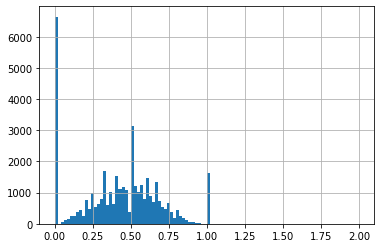

In [118]:
print(train_X.r1_teamfight_participation.value_counts().iloc[:10])
print(train_X.r1_teamfight_participation.describe())
train_X.r1_teamfight_participation.hist(bins = 100)

It seams like teamfight_participation is a proportion of the team fights that the player participated in. It should be in the range from 0 to 1. However, there are a few values, that are larger that 1. They need to be replaced with 1. A possible feature that can be formed from this variable during aggregation is number of players who participatted in more than 50 % of the team fights.

### General look at all variables

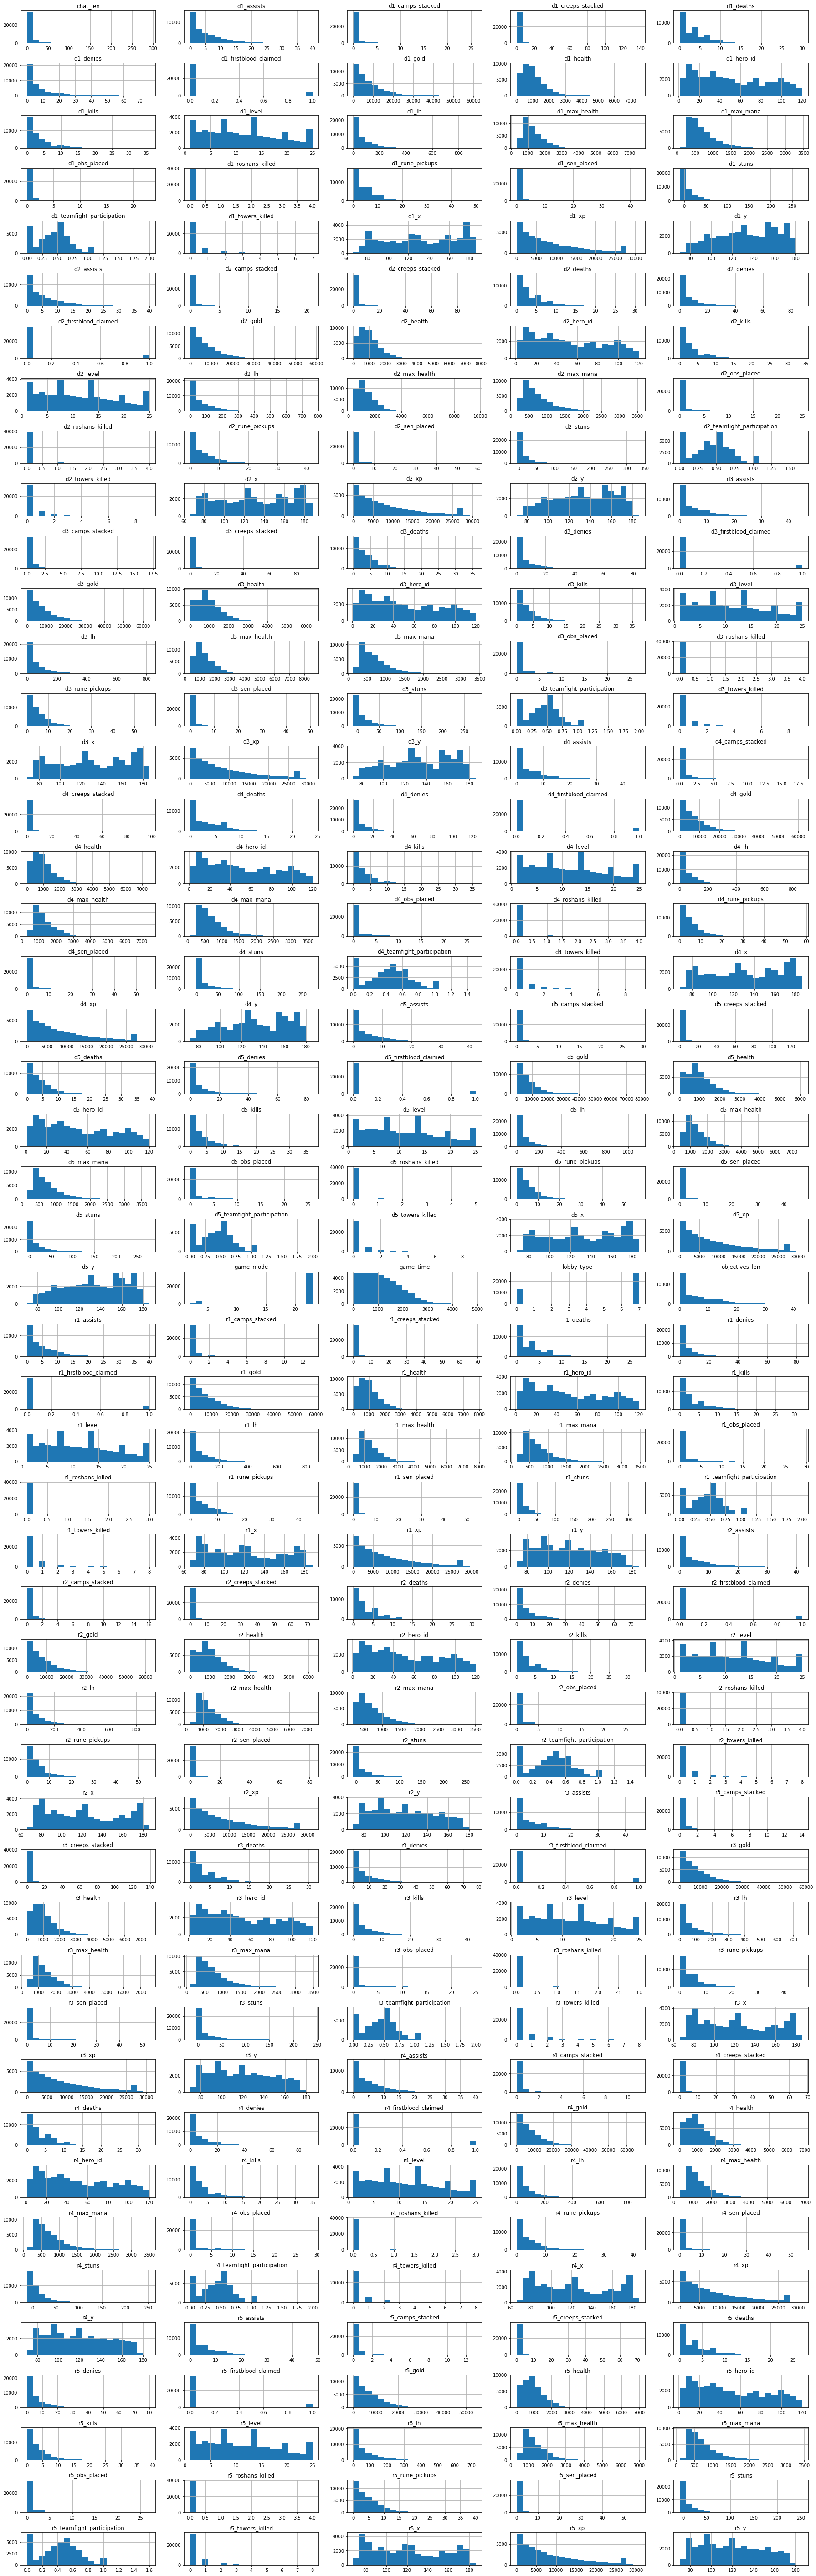

In [111]:
train_X.hist(figsize = (25,80),layout = (50,5), bins=20)
plt.tight_layout()
plt.show()

# 6. Check coordinates of the players

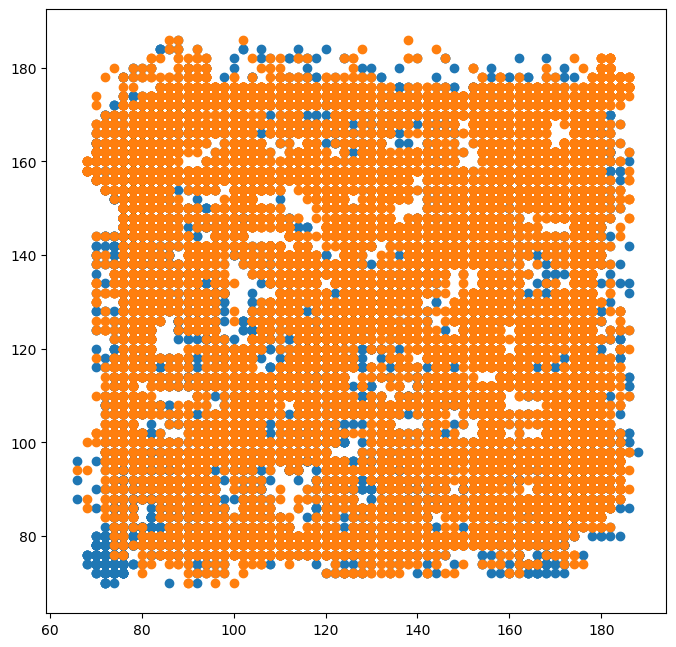

In [161]:
# exploring coordinates
x1 = train_X['r1_x']
y1 = train_X['r1_y']

x2 = train_X['d1_x']
y2 = train_X['d1_y']

plt.figure(figsize=(8,8))
plt.scatter(x1,y1)
plt.scatter(x2,y2)

Bottom left corner is only occupied by Dire team and top right corner is occupied by Radiant players only. The position of the filed should be also explored for the cases of Radiant's victory.

In [94]:
target = pd.read_csv('train_targets.csv', index_col = 'match_id_hash')
target.head()

,game_time,radiant_win,duration,time_remaining,next_roshan_team
match_id_hash,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,False,992,837,NaN
b9c57c450ce74a2af79c9ce96fac144d,658,True,1154,496,NaN
6db558535151ea18ca70a6892197db41,21,True,1503,1482,Radiant
46a0ddce8f7ed2a8d9bd5edcbb925682,576,True,1952,1376,NaN
b1b35ff97723d9b7ade1c9c3cf48f770,453,False,2001,1548,NaN


In [101]:
train_X_radiant = train_X[target.radiant_win]
train_X_dire = train_X[~target.radiant_win]

Text(0.5, 1.0, 'Dire')

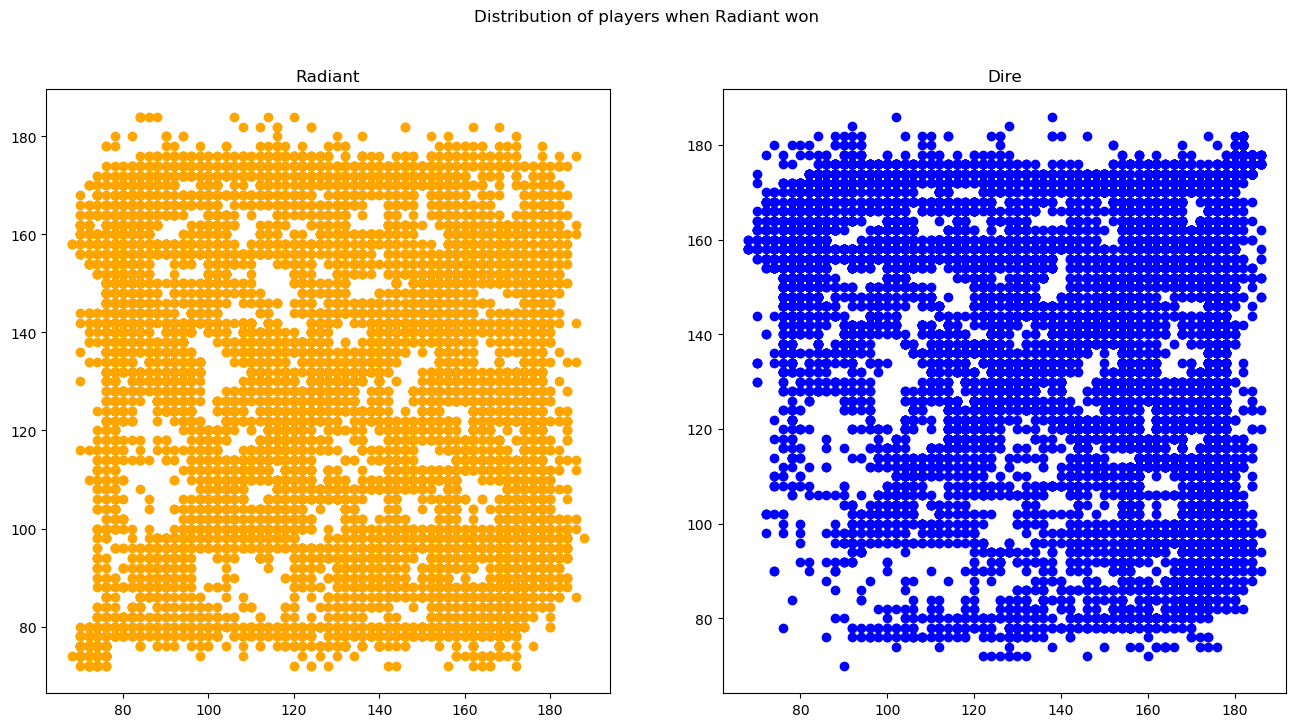

In [144]:
# coordinates distribution when Radiant won
x1 = train_X_radiant['r1_x']
y1 = train_X_radiant['r1_y']

x2 = train_X_radiant['d1_x']
y2 = train_X_radiant['d1_y']

fig, (ax1, ax2) = plt.subplots(1, 2 , figsize=(16,8))
fig.suptitle('Distribution of players when Radiant won')
ax1.scatter(x1,y1, color = 'orange')
ax1.set_title('Radiant')
ax2.scatter(x2,y2, color = 'blue')
ax2.set_title('Dire')



Text(0.5, 1.0, 'Dire')

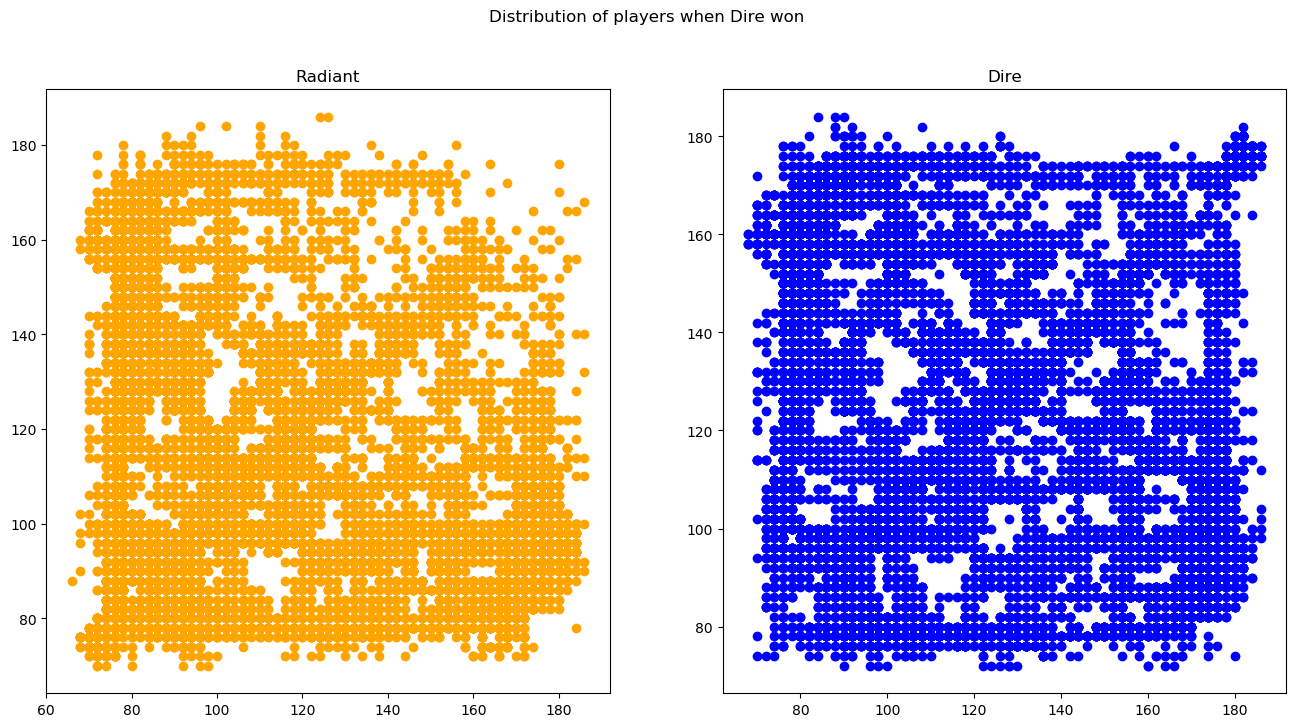

In [142]:
# coordinates distribution when Radiant lost
x1 = train_X_dire['r2_x']
y1 = train_X_dire['r2_y']

x2 = train_X_dire['d3_x']
y2 = train_X_dire['d3_y']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
fig.suptitle('Distribution of players when Dire won')
ax1.scatter(x1,y1, color = 'orange')
ax1.set_title('Radiant')
ax2.scatter(x2,y2, color = 'blue')
ax2.set_title('Dire')


Indeed, the distribution of the players on the map is different in cases when Radiant won or not. The players of the team that has won are spreded, on average, over the whole field. But the team, which has lost, has much more dense presence at its base and less dense presence at the opponent's base. The base for the Radiant is bottom left corner and the base for Dire is upper right corner. A new feature can be built based on coordinates: 'presence_at_opponent_base' which can be binary or an average of indicator function for all five players of the team. 

In [159]:
# identifying bases

print('Radiant: from x = {}, y = {}   to   x = {}, y = {}'.format(x1.min(), y1.min(), x1.min()+30, y1.min()+30))
print('Dire: from x = {}, y = {}   to   x = {}, y = {}'.format(x2.max()-30,y2.max()-30,x2.max(), y2.max()))

radiant_base_x = 96
radiant_base_y = 100

dire_base_x = 156
dire_base_y = 156

Radiant: from x = 66, y = 70   to   x = 96, y = 100
Dire: from x = 156, y = 156   to   x = 186, y = 186


70